# **Homework: LLM Orchestration and Ingestion**
It's possible that your answers won't match exactly. If it's the case, select the closest one.

Our FAQ documents change with time: students add more records and edit existing ones. We need to keep our index in sync.

There are two ways of doing it:

Incremental: you only update records that got changed, created or deleted
Full update: you recreate the entire index from scratch
In this homework, we'll look at full update. We will run our indexing pipeline daily and re-create the index from scracth each time we run.

For that, we created two FAQ documents for LLM Zoomcamp

version 1
version 2
First, we will run our ingestion pipeline with version 1 and then with version 2.

## Q1. Running Mage
Clone the same repo we used in the module and run mage:

git clone https://github.com/mage-ai/rag-project
Add the following libraries to the requirements document:

python-docx
elasticsearch
Make sure you use the latest version of mage:

docker pull mageai/mageai:llm
Start it:

./scripts/start.sh
Now mage is running on http://localhost:6789/

What's the version of mage?

## A1.

**0.9.72**

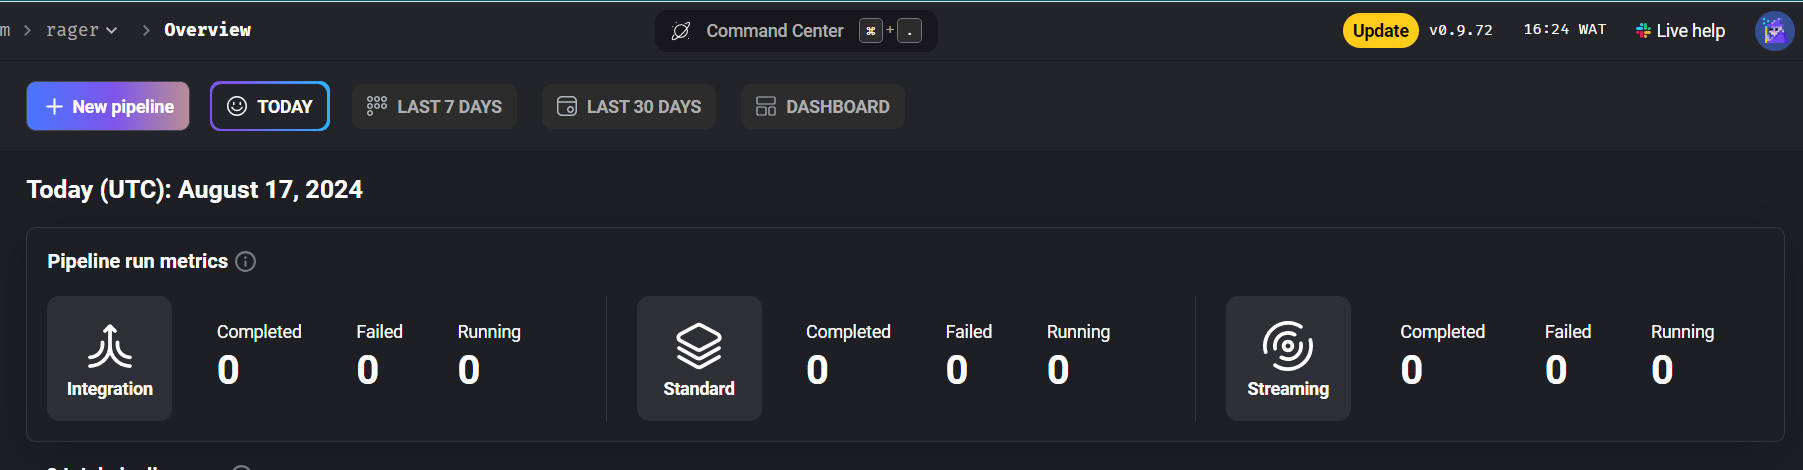

**Creating a RAG pipeline**

Create a RAG pipeline

## Q2. Reading the documents
Now we can ingest the documents. Create a custom code ingestion block

Let's read the documents. We will use the same code we used for parsing FAQ: parse-faq-llm.ipynb

Use the following document_id: 1qZjwHkvP0lXHiE4zdbWyUXSVfmVGzougDD6N37bat3E

Which is the document ID of LLM FAQ version 1

Copy the code to the editor How many FAQ documents we processed?

1
2
3
4

## A1.

**1**

Copy the code below and paste in the active ingestion block on Mage. I used API Data Loader.

In [ ]:
import io
import requests
import docx
from typing import List, Dict
from mage_ai.shared.hash import dig

if 'data_loader' not in globals():
    from mage_ai.data_preparation.decorators import data_loader
if 'test' not in globals():
    from mage_ai.data_preparation.decorators import test

# Function to clean text lines
def clean_line(line):
    line = line.strip()
    line = line.strip('\uFEFF')
    return line

# Function to read FAQ from a Google Doc
def read_faq(file_id):
    url = f'https://docs.google.com/document/d/{file_id}/export?format=docx'
    response = requests.get(url)
    response.raise_for_status()

    with io.BytesIO(response.content) as f_in:
        doc = docx.Document(f_in)

    questions = []
    question_heading_style = 'heading 2'
    section_heading_style = 'heading 1'

    section_title = ''
    question_title = ''
    answer_text_so_far = ''

    for p in doc.paragraphs:
        style = p.style.name.lower()
        p_text = clean_line(p.text)

        if len(p_text) == 0:
            continue

        if style == section_heading_style:
            section_title = p_text
            continue

        if style == question_heading_style:
            answer_text_so_far = answer_text_so_far.strip()
            if answer_text_so_far != '' and section_title != '' and question_title != '':
                questions.append({
                    'text': answer_text_so_far,
                    'section': section_title,
                    'question': question_title,
                })
                answer_text_so_far = ''

            question_title = p_text
            continue

        answer_text_so_far += '\n' + p_text

    answer_text_so_far = answer_text_so_far.strip()
    if answer_text_so_far != '' and section_title != '' and question_title != '':
        questions.append({
            'text': answer_text_so_far,
            'section': section_title,
            'question': question_title,
        })

    return questions

# Mage data loader function to ingest FAQ data from Google Docs
@data_loader
def ingest_faq_data(*args, **kwargs) -> List[Dict]:
    """
    Ingests FAQ data from Google Docs and returns it as a list of dictionaries.
    """
    faq_documents = {
        'llm-zoomcamp': '1qZjwHkvP0lXHiE4zdbWyUXSVfmVGzougDD6N37bat3E',
    }

    documents = []
    for course, file_id in faq_documents.items():
        course_documents = read_faq(file_id)
        documents.append({'course': course, 'documents': course_documents})

    return documents

# Test function for validating the output of the ingestion block
@test
def test_output(output, *args) -> None:
    """
    Validates that the output is not empty.
    """
    assert output is not None, 'The output is undefined'
    assert len(output) > 0, 'The output should contain data'

Just one document returned.

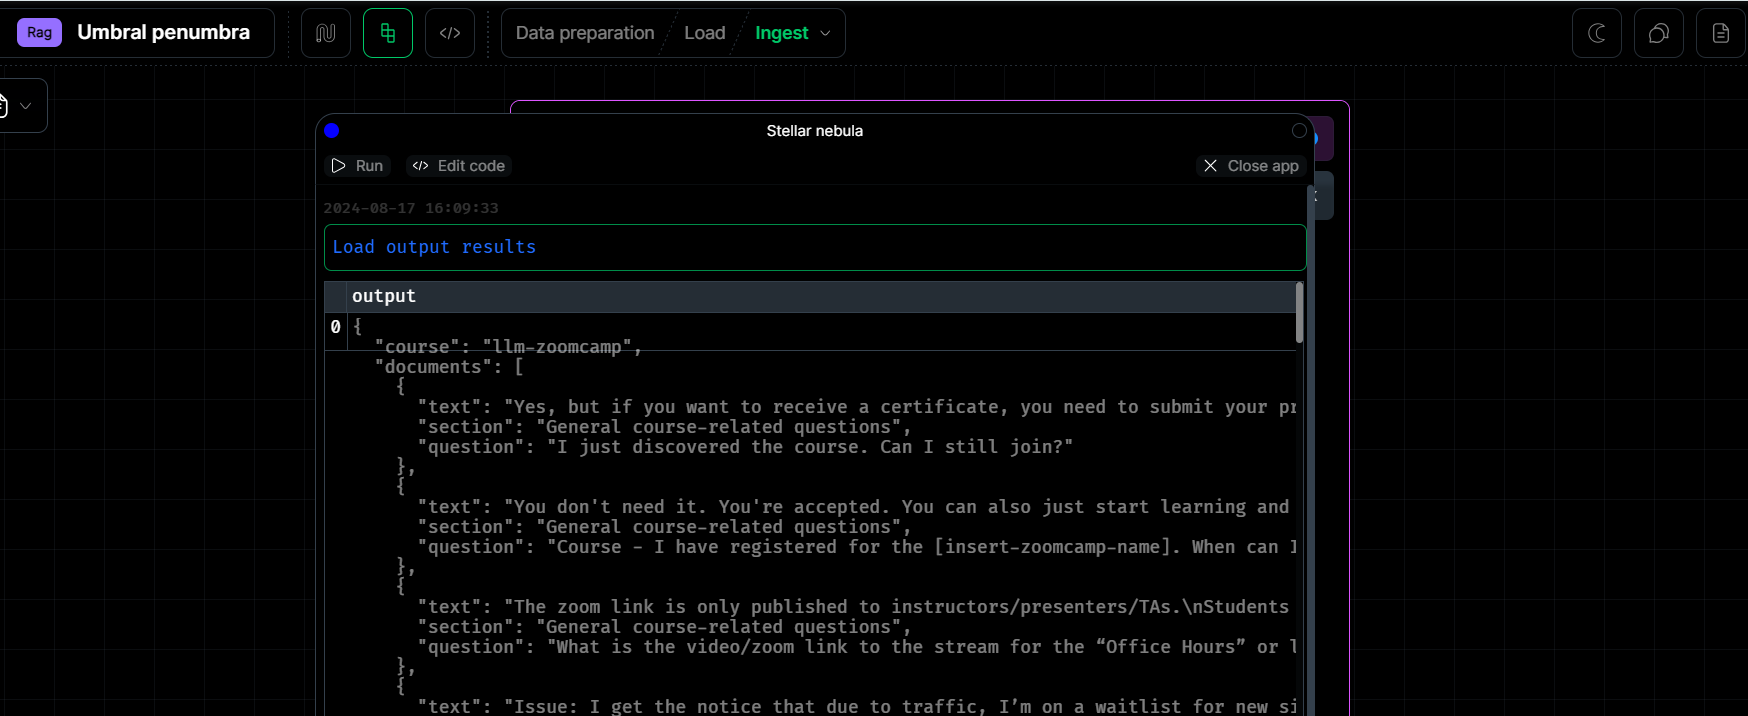

## Q3. Chunking
We don't really need to do any chuncking because our documents already have well-specified boundaries. So we just need to return the documents without any changes.

So let's go to the transformation part and add a custom code chunking block:

documents = []

for doc in data['documents']:
    doc['course'] = data['course']
    # previously we used just "id" for document ID
    doc['document_id'] = generate_document_id(doc)
    documents.append(doc)

print(len(documents))

return documents
Where data is the input parameter to the transformer.

And the generate_document_id is defined in the same way as in module 4:

import hashlib

def generate_document_id(doc):
    combined = f"{doc['course']}-{doc['question']}-{doc['text'][:10]}"
    hash_object = hashlib.md5(combined.encode())
    hash_hex = hash_object.hexdigest()
    document_id = hash_hex[:8]
    return document_id
Note: if instead of a single dictionary you get a list, add a for loop:

for course_dict in data:
    ...
You can check the type of data with this code:

print(type(data))


How many documents (chunks) do we have in the output?

* 66
* 76
* 86
* 96


Tokenization and embeddings
We don't need any tokenization, so we skip it.

Because currently it's required in mage, we can create a dummy code block:

Create a custom code block
Don't change it
Because we will use text search, we also don't need embeddings, so skip it too.

If you want to use sentence transformers - the ones from module 3 - you don't need tokenization, but need embeddings (you don't need it for this homework)

## A3.

**86**

Copy and run the following code on your active chunking block on Mage:

In [ ]:
import hashlib

if 'transformer' not in globals():
    from mage_ai.data_preparation.decorators import transformer
if 'test' not in globals():
    from mage_ai.data_preparation.decorators import test

def generate_document_id(doc):
    combined = f"{doc['course']}-{doc['question']}-{doc['text'][:10]}"
    hash_object = hashlib.md5(combined.encode())
    hash_hex = hash_object.hexdigest()
    document_id = hash_hex[:8]
    return document_id

@transformer
def transform(data, *args, **kwargs):
    """
    Transforms the input data by adding document IDs and ensuring each document
    is tagged with its course.

    Args:
        data: The output from the upstream parent block, expected to be a dictionary or list of dictionaries.

    Returns:
        A list of transformed documents.
    """
    documents = []

    # Check if the input data is a list of course dictionaries or a single dictionary
    if isinstance(data, list):
        for course_dict in data:
            for doc in course_dict['documents']:
                doc['course'] = course_dict['course']
                doc['document_id'] = generate_document_id(doc)
                documents.append(doc)
    else:
        for doc in data['documents']:
            doc['course'] = data['course']
            doc['document_id'] = generate_document_id(doc)
            documents.append(doc)

    print(len(documents))

    return documents

@test
def test_output(output, *args) -> None:
    """
    Tests the output of the transformation block to ensure it is properly formatted.
    """
    assert output is not None, 'The output is undefined'
    assert isinstance(output, list), 'The output should be a list'
    assert all('document_id' in doc for doc in output), 'Each document should have a document_id'

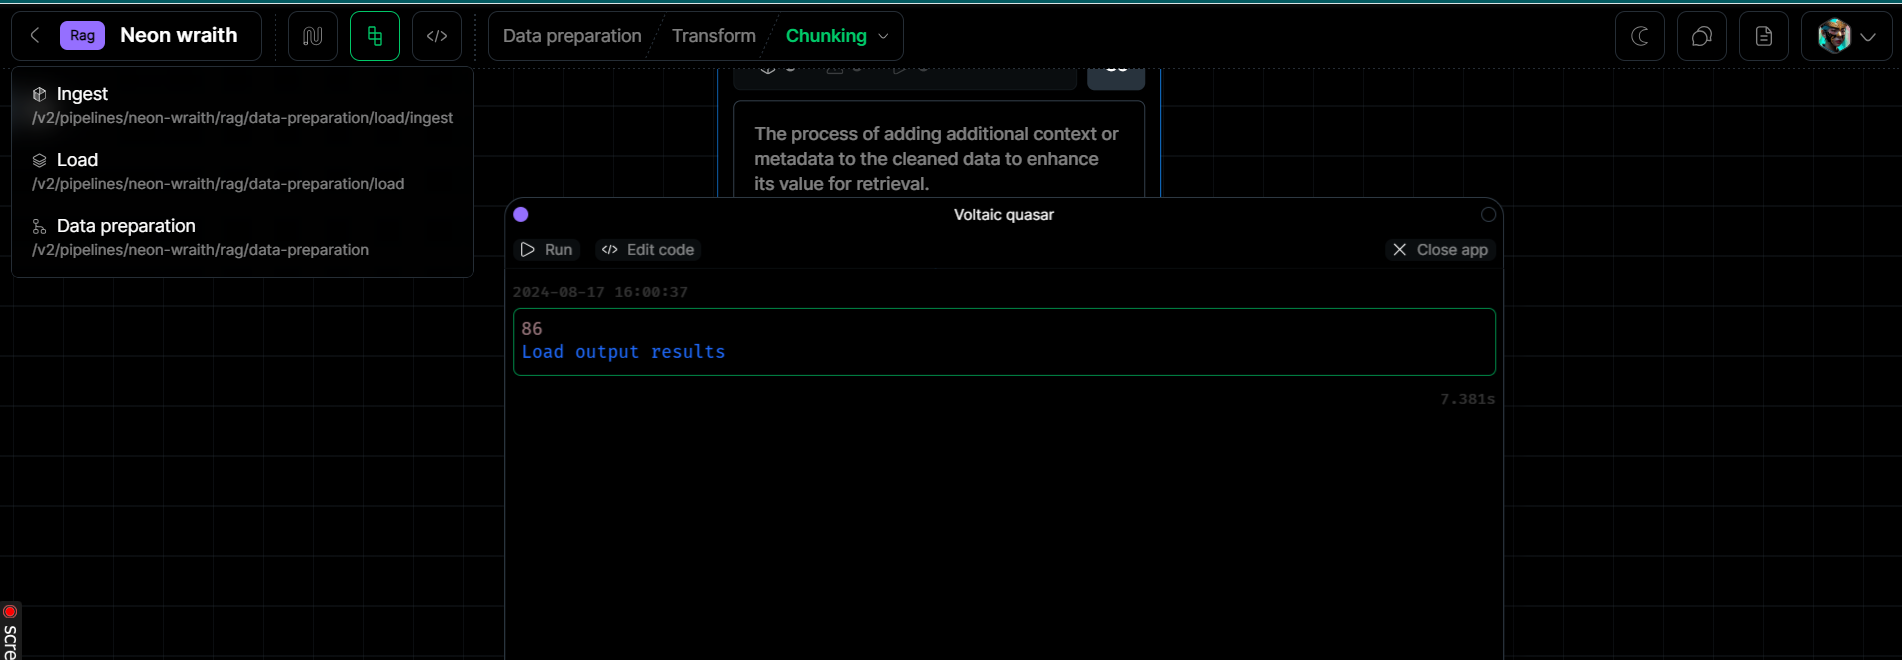





## Q4. Export
Now we're ready to index the data with elasticsearch. For that, we use the Export part of the pipeline

Go to the Export part
Select vector databases -> Elasticsearch
Open the code for editing
Because we won't use vector search, but usual text search, we will need to adjust the code.

First, let's change the line where we read the index name:

index_name = kwargs.get('index_name', 'documents')
To index_name_prefix - we will parametrize it with the day and time we run the pipeline

from datetime import datetime

index_name_prefix = kwargs.get('index_name', 'documents')
current_time = datetime.now().strftime("%Y%m%d_%M%S")
index_name = f"{index_name_prefix}_{current_time}"
print("index name:", index_name)
We will need to save the name in a global variable, so it can be accessible in other code blocks

from mage_ai.data_preparation.variable_manager import set_global_variable

set_global_variable('YOUR_PIPELINE_NAME', 'index_name', index_name)
Where your pipeline name is the name of the pipeline, e.g. transcendent_nexus (replace the space with underscore _)

Replace index settings with the settings we used previously:

```index_settings = {
    "settings": {
        "number_of_shards": number_of_shards,
        "number_of_replicas": number_of_replicas
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "document_id": {"type": "keyword"}
        }
    }
}```
Remove the embeddings line:

if isinstance(document[vector_column_name], np.ndarray):
    document[vector_column_name] = document[vector_column_name].tolist()
At the end (outside of the indexing for loop), print the last document:

print(document)
Now execute the block.

What's the last document id?

Also note the index name.

##A4.

**6fc3236a**

Copy and run the below code in the active Export block on Mage.

In [ ]:
from typing import Dict, List, Union
import numpy as np
from elasticsearch import Elasticsearch
from datetime import datetime
from mage_ai.data_preparation.variable_manager import set_global_variable

if 'data_exporter' not in globals():
    from mage_ai.data_preparation.decorators import data_exporter

@data_exporter
def elasticsearch(
    documents: List[Dict[str, Union[Dict, List[int], np.ndarray, str]]], *args, **kwargs,
):
    """
    Exports document data to an Elasticsearch database.
    """

    connection_string = kwargs.get('connection_string', 'http://localhost:9200')
    index_name_prefix = kwargs.get('index_name', 'documents')
    current_time = datetime.now().strftime("%Y%m%d_%M%S")
    index_name = f"{index_name_prefix}_{current_time}"
    number_of_shards = kwargs.get('number_of_shards', 1)
    number_of_replicas = kwargs.get('number_of_replicas', 0)

    set_global_variable('ragic', 'index_name', index_name)

    es_client = Elasticsearch(connection_string)

    print(f'Connecting to Elasticsearch at {connection_string}')

    index_settings = {
        "settings": {
            "number_of_shards": number_of_shards,
            "number_of_replicas": number_of_replicas
        },
        "mappings": {
            "properties": {
                "text": {"type": "text"},
                "section": {"type": "text"},
                "question": {"type": "text"},
                "course": {"type": "keyword"},
                "document_id": {"type": "keyword"}
            }
        }
    }

    if not es_client.indices.exists(index=index_name):
        es_client.indices.create(index=index_name, body=index_settings)
        print('Index created with properties:', index_settings)

    print(f'Indexing {len(documents)} documents to Elasticsearch index {index_name}')
    for document in documents:
        print(f'Indexing document {document["document_id"]}')
        es_client.index(index=index_name, document=document)

    print(document)  # Print the last document

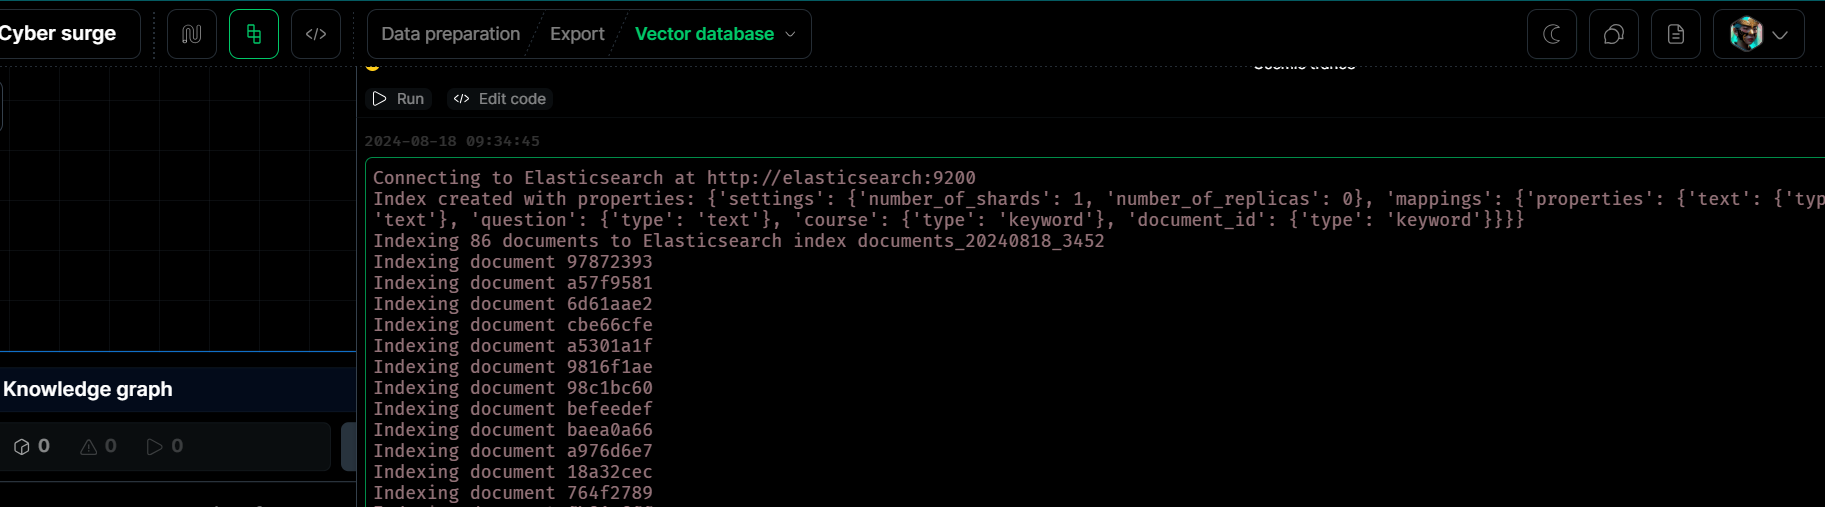

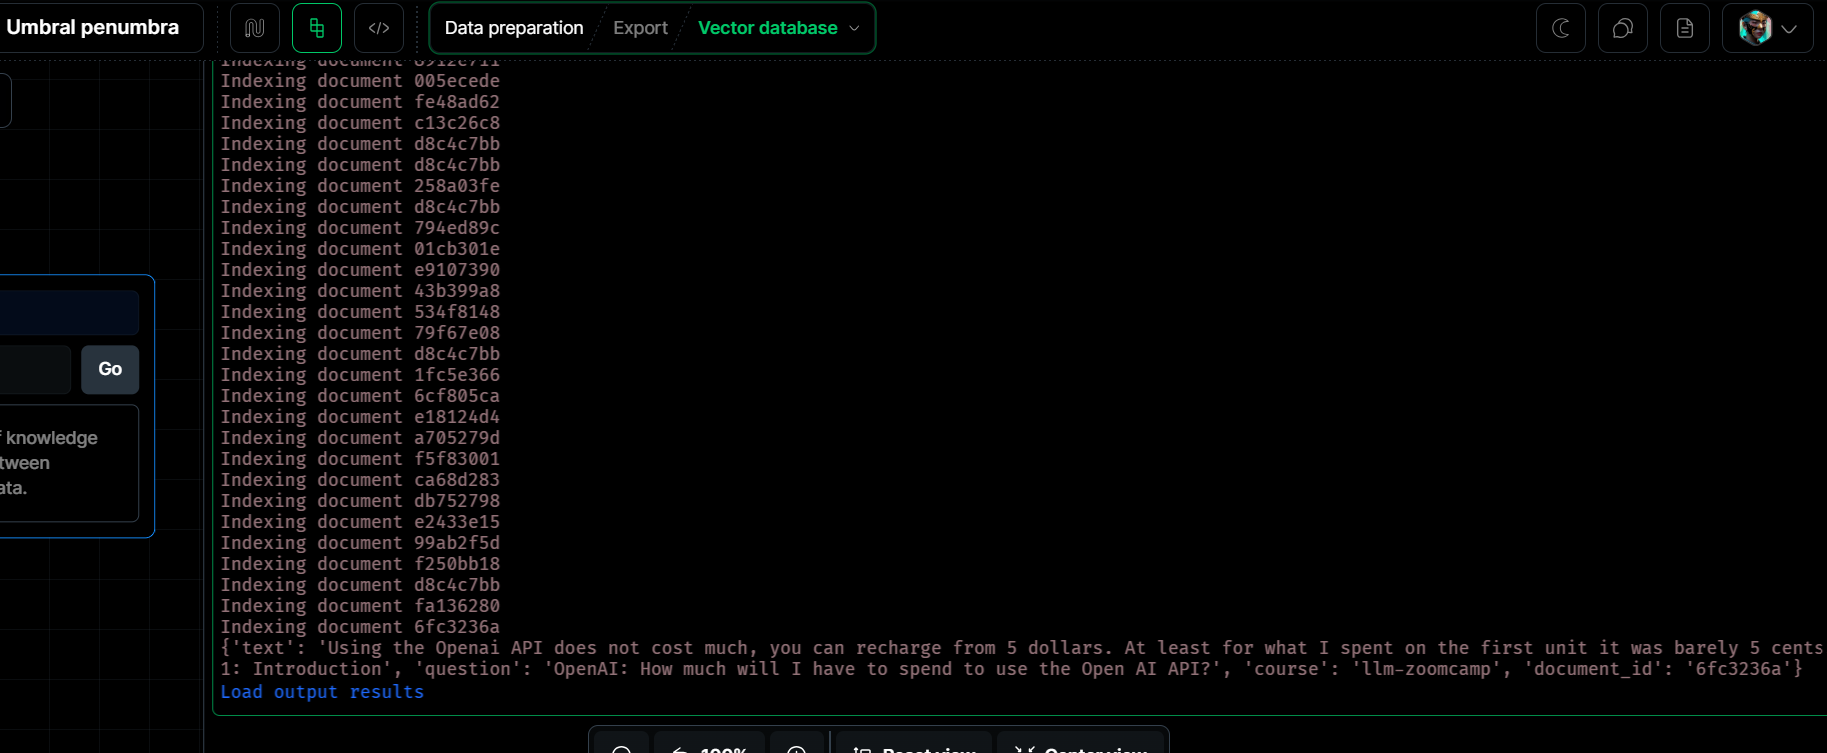

## Q5. Testing the retrieval
Now let's test the retrieval. Use mage or jupyter notebook to test it.

Let's use the following query: "When is the next cohort?"

What's the ID of the top matching result?

##A5.

**bf024675**

In [5]:
! pip install -qU elasticsearch

In [1]:
from elasticsearch import Elasticsearch

# Replace with your actual Elasticsearch URL and authentication details
es_client = Elasticsearch("http://localhost:9200")

# Verify connection
es_info = es_client.info()
print(es_info)

{'name': '47255d7153f7', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'UpABT0NJSI6BQYlm9riZoQ', 'version': {'number': '8.5.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'c94b4700cda13820dad5aa74fae6db185ca5c304', 'build_date': '2022-10-24T16:54:16.433628434Z', 'build_snapshot': False, 'lucene_version': '9.4.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


In [2]:
query = {
    "size": 5,
    "query": {
        "bool": {
            "must": {
                "multi_match": {
                    "query": "When is the next cohort?",
                    "fields": ["question^3"],  # Searching specifically in the 'question' field
                    "type": "best_fields"
                }
            },
            "filter": {
                "term": {
                    "course": "llm-zoomcamp"  # Filtering by the 'course' field
                }
            }
        }
    },
    "_source": ["question", "document_id"]  # Include 'question' and 'document_id' in the source fields
}

response = es_client.search(index="documents_20240818_3452", body=query)

# Display results and the document_id of the top matching result
for hit in response['hits']['hits']:
    print(f"Document ID: {hit['_source']['document_id']}, Question: {hit['_source']['question']}")


Document ID: bf024675, Question: When will the course be offered next?
Document ID: ee355823, Question: What is the cosine similarity?
Document ID: 6cf805ca, Question: There is an error when opening the table using dbtable = db.open_table("notion_pages___homework"): FileNotFoundError: Table notion_pages___homework does not exist.Please first call db.create_table(notion_pages___homework, data)
Document ID: e18124d4, Question: There is an error when running main(): FileNotFoundError: Table notion_pages___homework does not exist.Please first call db.create_table(notion_pages___homework, data)
Document ID: fb81c6ff, Question: I was working on next week’s homework/content - why does it keep changing?


In [3]:
# Check if there are any matching results
if response['hits']['hits']:
    # Get the ID of the top matching result
    top_hit_id = response['hits']['hits'][0]['_source']['document_id']
    print(f"Top Matching Result Document ID: {top_hit_id}")
else:
    print("No matching results found.")


Top Matching Result Document ID: bf024675






## Q6. Reindexing
Our FAQ document changes: every day course participants add new records or improve existing ones.

Imagine some time passed and the document changed. For that we have another version of the FAQ document: version 2.

The ID of this document is

**1T3MdwUvqCL3jrh3d3VCXQ8xE0UqRzI3bfgpfBq3ZWG0**.

Let's re-execute the entire pipeline with the updated data.

For the same query "When is the next cohort?". What's the ID of the top matching result?

## A6.

**b6fa77f3**

Use the code below to ingest the version 2 documents.

In [ ]:
import io
import requests
import docx
from typing import List, Dict
from mage_ai.shared.hash import dig

if 'data_loader' not in globals():
    from mage_ai.data_preparation.decorators import data_loader
if 'test' not in globals():
    from mage_ai.data_preparation.decorators import test

# Function to clean text lines
def clean_line(line):
    line = line.strip()
    line = line.strip('\uFEFF')
    return line

# Function to read FAQ from a Google Doc
def read_faq(file_id):
    url = f'https://docs.google.com/document/d/{file_id}/export?format=docx'
    response = requests.get(url)
    response.raise_for_status()

    with io.BytesIO(response.content) as f_in:
        doc = docx.Document(f_in)

    questions = []
    question_heading_style = 'heading 2'
    section_heading_style = 'heading 1'

    section_title = ''
    question_title = ''
    answer_text_so_far = ''

    for p in doc.paragraphs:
        style = p.style.name.lower()
        p_text = clean_line(p.text)

        if len(p_text) == 0:
            continue

        if style == section_heading_style:
            section_title = p_text
            continue

        if style == question_heading_style:
            answer_text_so_far = answer_text_so_far.strip()
            if answer_text_so_far != '' and section_title != '' and question_title != '':
                questions.append({
                    'text': answer_text_so_far,
                    'section': section_title,
                    'question': question_title,
                })
                answer_text_so_far = ''

            question_title = p_text
            continue

        answer_text_so_far += '\n' + p_text

    answer_text_so_far = answer_text_so_far.strip()
    if answer_text_so_far != '' and section_title != '' and question_title != '':
        questions.append({
            'text': answer_text_so_far,
            'section': section_title,
            'question': question_title,
        })

    return questions

# Mage data loader function to ingest FAQ data from Google Docs
@data_loader
def ingest_faq_data(*args, **kwargs) -> List[Dict]:
    """
    Ingests FAQ data from Google Docs and returns it as a list of dictionaries.
    """
    faq_documents = {
        'llm-zoomcamp': '1T3MdwUvqCL3jrh3d3VCXQ8xE0UqRzI3bfgpfBq3ZWG0',
    }

    documents = []
    for course, file_id in faq_documents.items():
        course_documents = read_faq(file_id)
        documents.append({'course': course, 'documents': course_documents})

    return documents

# Test function for validating the output of the ingestion block
@test
def test_output(output, *args) -> None:
    """
    Validates that the output is not empty.
    """
    assert output is not None, 'The output is undefined'
    assert len(output) > 0, 'The output should contain data'

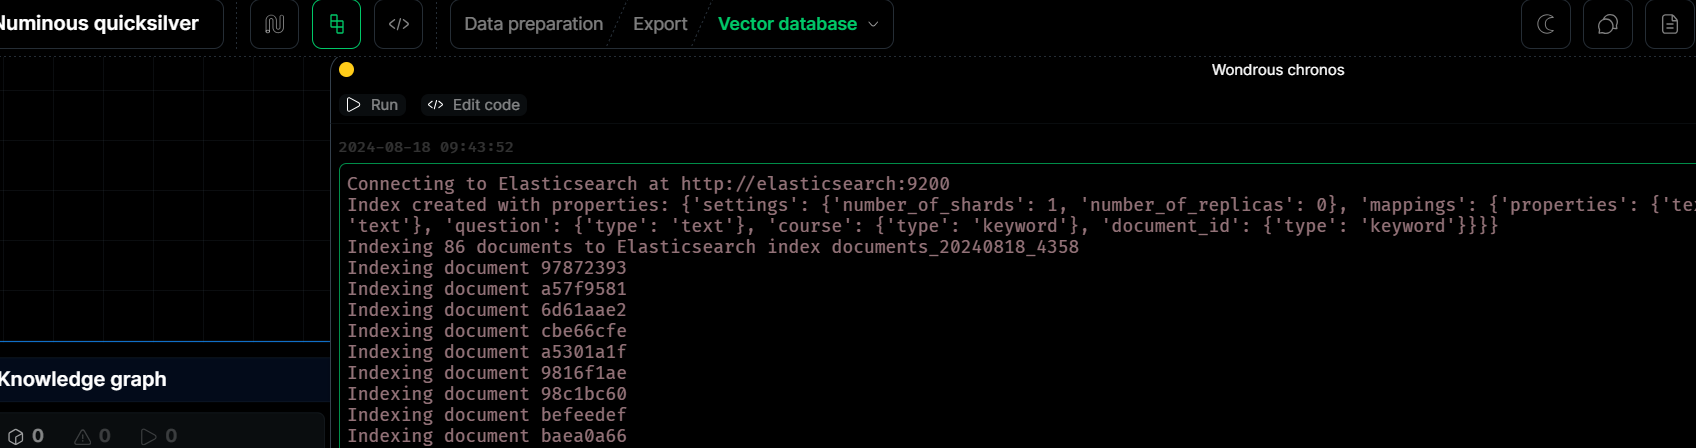

In [2]:
query = {
    "size": 5,
    "query": {
        "bool": {
            "must": {
                "multi_match": {
                    "query": "When is the next cohort?",
                    "fields": ["question^3", "text", "section"],
                    "type": "best_fields"
                }
            },
            "filter": {
                "term": {
                    "course": "llm-zoomcamp"
                }
            }
        }
    },
    "_source": ["text", "document_id"]  # Include "document_id" in the source fields
}

response = es_client.search(index="documents_20240818_4358", body=query)


if response['hits']['hits']:
    
    for hit in response['hits']['hits']:
        print(f"Document ID: {hit['_source']['document_id']}, Text: {hit['_source']['text']}")
else:
    print("No matching results found.")


Document ID: b6fa77f3, Text: Summer 2026.
Document ID: ee355823, Text: Cosine similarity is a measure used to calculate the similarity between two non-zero vectors, often used in text analysis to determine how similar two documents are based on their content. This metric computes the cosine of the angle between two vectors, which are typically word counts or TF-IDF values of the documents. The cosine similarity value ranges from -1 to 1, where 1 indicates that the vectors are identical, 0 indicates that the vectors are orthogonal (no similarity), and -1 represents completely opposite vectors.
Document ID: 6cf805ca, Text: The error indicates that you have not changed all instances of “employee_handbook” to “homework” in your pipeline settings
Document ID: e18124d4, Text: Make sure you open the correct table in line 3: dbtable = db.open_table("notion_pages___homework")
Document ID: fb81c6ff, Text: This course is being offered for the first time, and things will keep changing until a give

In [3]:
# Check if there are any matching results
if response['hits']['hits']:
    # Get the ID of the top matching result
    top_hit_id = response['hits']['hits'][0]['_source']['document_id']
    print(f"Top Matching Result Document ID: {top_hit_id}")
else:
    print("No matching results found.")

Top Matching Result Document ID: b6fa77f3
